<a href="https://colab.research.google.com/github/michaelmusun/ML-Projects/blob/main/Accurate-Air-Quality-Prediction-Time-Series-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import pandas as pd

from numpy import concatenate
import math
import statistics

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')


import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


In [108]:
df = pd.read_excel('Takapuna2.5.xlsx', header=4)  
# Rename Columns
df.columns = ['Start of Interval', 
              'End of Interval', 
              'Air Temp',
              'NO',
              'NO2',
              'Wind Speed',
              'PM2,5',
              'CO',
              'Solar Rad',
              'Wind Dir',
              'Rel Humidity'
              ]
# Reorder columns
df = df[['Start of Interval', 
              'End of Interval', 
              'Air Temp',
              'NO',
              'NO2',
              'Wind Speed',
              'CO',
              'Solar Rad',
              'Wind Dir',
              'Rel Humidity',
              'PM2,5'
              ]]
df['lag1'] = df['PM2,5'].shift(1)
df['lag2'] = df['PM2,5'].shift(2)
df['Start of Interval'] = pd.to_datetime(df['Start of Interval'])
df['End of Interval'] = pd.to_datetime(df['End of Interval'])
# delete nan rows, optionally
df

,Start of Interval,End of Interval,Air Temp,NO,NO2,Wind Speed,CO,Solar Rad,Wind Dir,Rel Humidity,"PM2,5",lag1,lag2
0,2017-01-01 00:00:00,2017-01-01 01:00:00,17.5,22.10,26.60,0.30,NaN,0.55,216.5,73.70,11.20,NaN,NaN
1,2017-01-01 01:00:00,2017-01-01 02:00:00,17.5,13.20,23.40,0.25,NaN,0.80,144.5,79.35,13.05,11.20,NaN
2,2017-01-01 02:00:00,2017-01-01 03:00:00,17.0,NaN,NaN,0.25,NaN,0.85,166.0,81.80,13.95,13.05,11.20
3,2017-01-01 03:00:00,2017-01-01 04:00:00,16.5,NaN,NaN,0.30,NaN,0.70,141.0,82.55,9.40,13.95,13.05
4,2017-01-01 04:00:00,2017-01-01 05:00:00,16.0,1.90,12.50,0.45,NaN,1.25,104.0,82.90,4.10,9.40,13.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2021-12-30 19:00:00,2021-12-30 20:00:00,19.0,4.15,3.80,3.25,NaN,NaN,230.5,56.55,4.05,4.10,4.20
43796,2021-12-30 20:00:00,2021-12-30 21:00:00,18.5,3.90,4.15,2.60,NaN,NaN,230.0,61.50,4.15,4.05,4.10
43797,2021-12-30 21:00:00,2021-12-30 22:00:00,18.0,3.35,3.85,2.30,NaN,NaN,234.0,64.80,4.20,4.15,4.05
43798,2021-12-30 22:00:00,2021-12-30 23:00:00,18.0,2.90,3.40,2.10,NaN,NaN,238.5,66.35,4.15,4.20,4.15


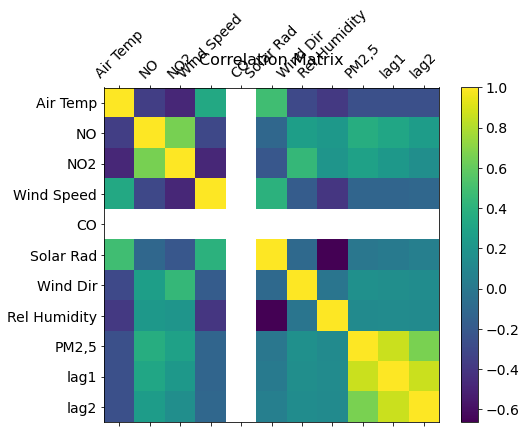

In [3]:
f = plt.figure(figsize=(8, 6))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

plt.show()



In [4]:
corr = df.iloc[:,2:].corr()['PM2,5'].abs().sort_values(ascending=False)
# display(corr)
display(corr.iloc[1:6])
print()
highest_corr = list(corr.iloc[1:6].index)
print(f"Highest correlation features: {highest_corr}")

lag1        0.867423
lag2        0.668474
NO          0.375863
NO2         0.291274
Air Temp    0.257376
Name: PM2,5, dtype: float64


Highest correlation features: ['lag1', 'lag2', 'NO', 'NO2', 'Air Temp']


In [5]:
df_list = [df[highest_corr], df[['PM2,5']]]
chosen_df = pd.concat(df_list, axis = 1)
chosen_df = chosen_df.fillna(method='ffill')
chosen_df = chosen_df.iloc[2:]
chosen_df

,lag1,lag2,NO,NO2,Air Temp,"PM2,5"
2,13.05,11.20,13.20,23.40,17.0,13.95
3,13.95,13.05,13.20,23.40,16.5,9.40
4,9.40,13.95,1.90,12.50,16.0,4.10
5,4.10,9.40,8.95,13.70,15.5,3.05
6,3.05,4.10,17.15,18.65,15.5,3.30
...,...,...,...,...,...,...
43795,4.10,4.20,4.15,3.80,19.0,4.05
43796,4.05,4.10,3.90,4.15,18.5,4.15
43797,4.15,4.05,3.35,3.85,18.0,4.20
43798,4.20,4.15,2.90,3.40,18.0,4.15


In [109]:
import plotly.express as px
fig = px.line(x=df['Start of Interval'], y=df['PM2,5'])
fig.show()

In [65]:
chosen_df.describe()

,lag1,lag2,NO,NO2,Air Temp,"PM2,5"
count,43798.000000,43798.000000,43798.000000,43798.000000,43798.000000,43798.000000
mean,6.028896,6.029057,13.012277,13.218531,15.752386,6.028693
std,3.925602,3.925670,26.089707,12.187955,3.633660,3.925469
min,-22.500000,-22.500000,-0.900000,-2.950000,2.000000,-22.500000
25%,4.000000,4.000000,1.450000,4.000000,13.500000,4.000000
50%,5.050000,5.050000,5.450000,9.000000,15.000000,5.050000
75%,7.050000,7.050000,13.000000,19.200000,18.000000,7.050000
max,54.900000,54.900000,422.050000,87.750000,28.000000,54.900000


In [6]:
X = chosen_df.drop('PM2,5', axis=1)
y = chosen_df[['PM2,5']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

MLP single layer 25 neurons

In [7]:
mlpr = MLPRegressor(hidden_layer_sizes=(25))
mlpr.fit(X_train, y_train)
mlpr.predict(X_test[:2])

mlpr.score(X_test, y_test)

0.8139415787313665

MLP two layers 1-24 neurons

In [8]:
mlpr_dict = {}

for i in range(1, 25): # 1-24 neurons moved to second layer
    print(f"{i} ", end='')
    mlpr = MLPRegressor(hidden_layer_sizes=(25-i, i))
    mlpr.fit(X_train, y_train)

    mlpr_dict[i] = mlpr.score(X_test, y_test)

display(mlpr_dict)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

{1: 0.730478686652269,
 2: 0.8206319024704312,
 3: 0.8145850303780321,
 4: 0.811841496685728,
 5: 0.8136685741571852,
 6: 0.8204457734459104,
 7: 0.822920075787924,
 8: 0.8190648141702248,
 9: 0.8237336695866985,
 10: 0.8263677185105587,
 11: 0.8195969423683498,
 12: 0.8159989197397909,
 13: 0.8163005720615584,
 14: 0.823195928310175,
 15: 0.8234791750440195,
 16: 0.8203313189966528,
 17: 0.813929982493361,
 18: 0.8132085739955314,
 19: 0.8105917388977325,
 20: 0.8198876161290696,
 21: 0.8184398605334711,
 22: 0.817945646589916,
 23: 0.8153548725860226,
 24: 0.811700048420017}

In [10]:
# Plot the above data
# https://plotly.com/python/line-and-scatter/

MLP Results

In [100]:
# Optimal MLP 2 layer split: 15/10
mlpr = MLPRegressor(hidden_layer_sizes=(15, 10))
mlpr.fit(X_train, y_train)

# make a prediction
yhat = mlpr.predict(X_test)
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(y_test, yhat)
print('Test MAE:  %.3f' % mae)

r2 = r2_score(y_test, yhat)
print('Test R-Squared:  %.3f' % r2)

final_mlp_pred = yhat
final_mlp_true = y_test

mlp_RMSE = rmse
mlp_MAE = mae
mlp_r2 = r2

Test RMSE: 1.678
Test MAE:  0.830
Test R-Squared:  0.822


LSTM

LSTM 2)

In [43]:
split = int(chosen_df.shape[0]*0.7)

train = chosen_df[:split]
test = chosen_df.drop(train.index)

train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


adam = Adam(
    learning_rate=0.01,
)

# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=adam)
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/30
7665/7665 - 15s - loss: 1.2542 - val_loss: 1.4465 - 15s/epoch - 2ms/step
Epoch 2/30
7665/7665 - 14s - loss: 1.1384 - val_loss: 1.4366 - 14s/epoch - 2ms/step
Epoch 3/30
7665/7665 - 14s - loss: 1.1164 - val_loss: 1.5571 - 14s/epoch - 2ms/step
Epoch 4/30
7665/7665 - 13s - loss: 1.0738 - val_loss: 1.5705 - 13s/epoch - 2ms/step
Epoch 5/30
7665/7665 - 14s - loss: 1.0508 - val_loss: 1.4037 - 14s/epoch - 2ms/step
Epoch 6/30
7665/7665 - 14s - loss: 1.0534 - val_loss: 1.3221 - 14s/epoch - 2ms/step
Epoch 7/30
7665/7665 - 18s - loss: 1.0572 - val_loss: 1.2722 - 18s/epoch - 2ms/step
Epoch 8/30
7665/7665 - 19s - loss: 1.0372 - val_loss: 1.4697 - 19s/epoch - 2ms/step
Epoch 9/30
7665/7665 - 14s - loss: 1.0548 - val_loss: 1.4938 - 14s/epoch - 2ms/step
Epoch 10/30
7665/7665 - 14s - loss: 1.0155 - val_loss: 1.0713 - 14s/epoch - 2ms/step
Epoch 11/30
7665/7665 - 16s - loss: 1.0025 - val_loss: 1.0435 - 16s/epoch - 2ms/step
Epoch 12/30
7665/7665 - 17s - loss: 1.0008 - val_loss: 1.2687 - 17s/epoch 

dict_keys(['loss', 'val_loss'])


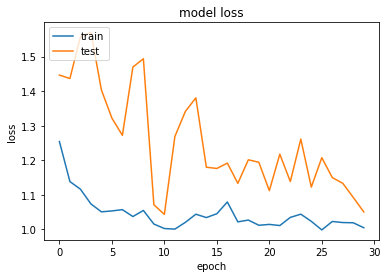

Mean Loss:	1.044
Stddev of Loss:	0.05
Min Loss:	0.998
Max Loss:	1.254


In [44]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(f"Mean Loss:\t{round(sum(history.history['loss'])/len(history.history['loss']), 3)}")
print(f"Stddev of Loss:\t{round(statistics.pstdev(history.history['loss']), 3)}")
print(f"Min Loss:\t{round(min(history.history['loss']), 3)}")
print(f"Max Loss:\t{round(max(history.history['loss']), 3)}")

LSTM 3)

In [55]:
for batch_size in [4, 20, 50, 100]:
    split = int(chosen_df.shape[0]*0.7)

    train = chosen_df[:split]
    test = chosen_df.drop(train.index)

    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

    train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
    # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


    adam = Adam(
        learning_rate=0.01,
    )

    # design network
    model = Sequential()
    model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=adam)
    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=batch_size, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    print(f"Batch {batch_size} Loss:\t{round(min(history.history['loss']), 3)}")

Batch 4 Loss:	1.054
Batch 20 Loss:	1.063
Batch 50 Loss:	1.135
Batch 100 Loss:	1.31


LSTM 4)

In [58]:
for neurons in [5, 10, 25, 50]:
    split = int(chosen_df.shape[0]*0.7)

    train = chosen_df[:split]
    test = chosen_df.drop(train.index)

    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

    train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
    # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


    adam = Adam(
        learning_rate=0.01,
    )

    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=adam)
    # fit network
    history = model.fit(train_X, train_y, epochs=21, batch_size=4, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    print(f"#Neurons={neurons} Loss:\t{round(min(history.history['loss']), 3)}")

#Neurons=5 Loss:	1.099
#Neurons=10 Loss:	0.986
#Neurons=25 Loss:	0.994
#Neurons=50 Loss:	0.974


LSTM RMSE
Optimal Epochs: 21
Optimal Batch Size: 4
Optimal Neurons in Hidden Layer: 50

In [104]:
split = int(chosen_df.shape[0]*0.7)

train = chosen_df[:split]
test = chosen_df.drop(train.index)

train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


adam = Adam(
    learning_rate=0.01,
)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=adam)
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=4, validation_data=(test_X, test_y), verbose=0, shuffle=False)



# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.values.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('LSTM RMSE: %.3f' % rmse)

mae = mean_absolute_error(inv_y, inv_yhat)
print('LSTM MAE:  %.3f' % mae)

r2 = r2_score(inv_y, inv_yhat)
print('LSTM R-Squared:  %.3f' % r2)

final_lstm_pred = yhat
final_lstm_true = test_y

LSTM RMSE: 1.871
LSTM MAE:  1.191
LSTM R-Squared:  0.741


In [103]:
print(f"MLP RMSE: {mlp_RMSE}")
print(f"MLP MAE: {mlp_MAE}") 
print(f"MLP R-Squared: {mlp_r2}")

MLP RMSE: 1.678308861129364
MLP MAE: 0.8298927633698607
MLP-R Squared: 0.8218719288130996


In [99]:
# MLP Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=[*range(len(final_mlp_pred))], y=final_mlp_pred,
                    mode='lines+markers',
                    name='MLP PREDICTION'))
fig.add_trace(go.Scatter(x=[*range(len(final_mlp_true['PM2,5']))], y=final_mlp_true['PM2,5'],
                    mode='lines+markers',
                    name='MLP TRUE'))
fig.update_layout(
    title='MLP'
)
fig.show()



# LSTM Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=[*range(len(final_lstm_pred))], y=[*final_lstm_pred.squeeze()],
                    mode='lines+markers',
                    name='LSTM PREDICTION'))
fig.add_trace(go.Scatter(x=[*range(len(final_lstm_true))], y=[*final_lstm_true.squeeze()],
                    mode='lines+markers',
                    name='LSTM TRUE'))
fig.update_layout(
    title='LSTM'
)
fig.show()